In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch

# Define date range
start_date = "2020-01-01"
end_date = "2025-01-01"

# Download AAPL data
try:
    df_aapl = yf.download("AAPL", start=start_date, end=end_date)
except Exception as e:
    print(f"AAPL download failed: {e}")

df_aapl.reset_index(inplace=True)
df_aapl = df_aapl.dropna()
df_aapl['Adj Close'] = df_aapl['Close']  # Add Adjusted Close as a copy of Close
df_aapl['AAPL_Returns'] = df_aapl['Adj Close'].pct_change()
df_aapl = df_aapl.dropna()  # Remove first row with NaN

# Download S&P 500 data
try:
    df_sp500 = yf.download("^GSPC", start=start_date, end=end_date)
except Exception as e:
    print(f"S&P 500 download failed: {e}")

df_sp500.reset_index(inplace=True)
df_sp500 = df_sp500.dropna()
df_sp500['Adj Close'] = df_sp500['Close']
df_sp500['SP500_Returns'] = df_sp500['Adj Close'].pct_change()
df_sp500 = df_sp500.dropna()


# Quick check
dates = df_aapl["Date"]
dates

# Merge AAPL and S&P 500 returns by Date
df = pd.merge(df_aapl[['Date', 'AAPL_Returns']],
              df_sp500[['Date', 'SP500_Returns']],
              on='Date', how='inner')

# Extract returns
aapl_returns = df['AAPL_Returns'].values
sp500_returns = df['SP500_Returns'].values

# Convert to Torch tensors
aapl_torch = torch.tensor(aapl_returns, dtype=torch.float32)
sp500_torch = torch.tensor(sp500_returns, dtype=torch.float32)

# Quick checks
print("S&P 500 mean:", sp500_torch.mean().item())
print("AAPL mean:", aapl_torch.mean().item())
len(aapl_torch), len(sp500_torch)  


/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/531643375.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_aapl = yf.download("AAPL", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/531643375.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_sp500 = yf.download("^GSPC", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

S&P 500 mean: 0.0005608699284493923
AAPL mean: 0.0011821100488305092


(1257, 1257)

In [3]:
import plotly.express as px
import numpy as np

# Create a line plot
fig = px.line(x=dates, y=sp500_returns, labels={'x':'Time (months ago)', 'y':'Portfolio Returns'}, 
              title="Portfolio Returns Over Time")

fig.show()



### Lower Partial Moment (LPM)

The Lower Partial Moment of order \(r\) with target \(\tau\) is:

$$
\text{LPM}_r(\tau) = \frac{1}{N} \sum_{i=1}^{N} \max(0, \tau - x_i)^r
$$

### Upper Partial Moment (UPM)

The Upper Partial Moment of order \(r\) with target \(\tau\) is:

$$
\text{UPM}_r(\tau) = \frac{1}{N} \sum_{i=1}^{N} \max(0, x_i - \tau)^r
$$


In [4]:
def LPM(degree: int, target: float = None, variables: list = None, excess_ret: bool = False):
    if target is None: 
        target = np.mean(variables)
    if excess_ret: 
        variables = [x-target for x in variables]
        target = 0
    s = 0.0
    for i in variables: 
        s += np.maximum(target-i, 0)**degree
    return s / len(variables)

def UPM(degree: int, target: float = None, variables: list = None, excess_ret: bool = False):
    if target is None: 
        target = np.mean(variables)
    if excess_ret: 
        variables = [x-target for x in variables]
        target = 0
    s = 0.0
    for i in variables: 
        s += np.maximum((i-target), 0)**degree
    return s / len(variables)

lpm_val =LPM(degree=1, target= 0.00, variables=sp500_returns, excess_ret=False)
upm_val = UPM(degree=1, target= 0.00, variables=sp500_returns, excess_ret=False)
mean = upm_val - lpm_val


print(lpm_val, upm_val)
print(f"lpm, upm mean: {mean}")
print("Portfolio mean:", sp500_torch.mean().item())

0.0041422051627118504 0.004703075146773056
lpm, upm mean: 0.0005608699840612052
Portfolio mean: 0.0005608699284493923


In [5]:
lpm_val = LPM(degree=1, target=0.0, variables=sp500_returns)
upm_val = UPM(degree=1, target=0.0, variables=sp500_returns)
mean_from_pm = upm_val - lpm_val

print("LPM:", lpm_val)
print("UPM:", upm_val)
print("Mean from partial moments:", mean_from_pm)
print("Actual mean:", np.mean(sp500_returns))

LPM: 0.0041422051627118504
UPM: 0.004703075146773056
Mean from partial moments: 0.0005608699840612052
Actual mean: 0.0005608699840612038


In [6]:
import numpy as np
from numba import njit

@njit(parallel=True)
def LPM_numba(degree: int, target: float = None, variables: list = None, excess_ret: bool = False):
    variables = np.asarray(variables)  # forces array type for Numba
    if target is None: 
        target = np.mean(variables)
    if excess_ret: 
        variables = variables - target
        target = 0
    s = 0.0
    for i in variables: 
        s += np.maximum(target-i, 0)**degree
    return s / len(variables)

@njit(parallel=True)
def UPM_numba(degree: int, target: float = None, variables: list = None, excess_ret: bool = False):
    if target is None: 
        target = np.mean(variables)
    if excess_ret: 
        variables = variables - target
        target = 0
    s = 0.0
    for i in variables: 
        s += np.maximum((i-target), 0)**degree
    return s / len(variables)

lpm_val = LPM_numba(degree=1, target=0.0, variables=sp500_returns)
upm_val = UPM_numba(degree=1, target=0.0, variables=sp500_returns)
mean_from_pm = upm_val - lpm_val

print("LPM:", lpm_val)
print("UPM:", upm_val)
print("Mean from partial moments:", mean_from_pm)
print("Actual mean:", np.mean(sp500_returns))


LPM: 0.0041422051627118504
UPM: 0.004703075146773056
Mean from partial moments: 0.0005608699840612052
Actual mean: 0.0005608699840612038


In [7]:
import torch

# Pick device: CUDA > MPS (Apple Silicon) > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

    
def LPM_torch(degree: int, target: float = None, variables=None, excess_ret: bool = False):
    variables = torch.as_tensor(variables, dtype=torch.float64)
    if target is None:
        target = variables.mean()
    if excess_ret:
        variables = variables - target
        target = 0.0
    
    if degree == 0:
        # Indicator for X <= τ (empirical CDF at τ)
        return (variables <= target).to(torch.float64).mean().item()

    diff = torch.clamp(target - variables, min=0)
    return (diff ** degree).mean().item()  # .item() for scalar Python value

def UPM_torch(degree: int, target: float = None, variables=None, excess_ret: bool = False):
    variables = torch.as_tensor(variables, dtype=torch.float64)
    if target is None:
        target = variables.mean()
    if excess_ret:
        variables = variables - target
        target = 0.0
    if degree == 0:
        # Indicator for X >= τ (1 - empirical CDF at τ)
        return (variables >= target).to(torch.float64).mean().item()
    diff = torch.clamp(variables - target, min=0)
    return (diff ** degree).mean().item()

# Compute
lpm_val = LPM_torch(degree=1, target= 0.00, variables=sp500_torch)
upm_val = UPM_torch(degree=1, target= 0.00, variables=sp500_torch)
diff = upm_val - lpm_val

print("LPM:", lpm_val)
print("UPM:", upm_val)
print("UPM - LPM:", diff)
print("Mean from numpy:", np.mean(sp500_returns))

LPM: 0.00414220515914292
UPM: 0.004703075137439423
UPM - LPM: 0.0005608699782965031
Mean from numpy: 0.0005608699840612038


In [8]:
# NumPy loop

%time LPM(degree=1, target= 0.00, variables=sp500_returns, excess_ret=False)
%time UPM(degree=1, target= 0.00, variables=sp500_returns, excess_ret=False)

# Numba (first call includes compilation)
%time LPM_numba(degree=1, target=0.0, variables=sp500_returns)
%time UPM_numba(degree=1, target=0.0, variables=sp500_returns)

# PyTorch on current device
%time LPM_torch(degree=1, target= 0.00, variables=sp500_torch)
%time UPM_torch(degree=1, target= 0.00, variables=sp500_torch)


# OUTPUTS
# CPU times: user 2 μs, sys: 1 μs, total: 3 μs
# Wall time: 5.01 μs
# CPU times: user 2 μs, sys: 1 μs, total: 3 μs
# Wall time: 5.25 μs
# CPU times: user 3 μs, sys: 1e+03 ns, total: 4 μs
# Wall time: 5.25 μs


CPU times: user 1.14 ms, sys: 62 μs, total: 1.2 ms
Wall time: 1.34 ms
CPU times: user 922 μs, sys: 8 μs, total: 930 μs
Wall time: 931 μs
CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 10 μs
CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 5.96 μs
CPU times: user 166 μs, sys: 85 μs, total: 251 μs
Wall time: 128 μs
CPU times: user 432 μs, sys: 762 μs, total: 1.19 ms
Wall time: 931 μs


0.004703075137439423

In [9]:
import time

def timed_run(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    elapsed_ms = (end - start) * 1000  # convert to milliseconds
    return result, elapsed_ms

# NumPy loop
lpm_np, lpm_np_time = timed_run(LPM, degree=1, target=0.0, variables=sp500_returns, excess_ret=False)
upm_np, upm_np_time = timed_run(UPM, degree=1, target=0.0, variables=sp500_returns, excess_ret=False)

# Numba (first call includes compilation)
lpm_nb, lpm_nb_time = timed_run(LPM_numba, degree=1, target=0.0, variables=sp500_returns)
upm_nb, upm_nb_time = timed_run(UPM_numba, degree=1, target=0.0, variables=sp500_returns)

# PyTorch
lpm_t, lpm_t_time = timed_run(LPM_torch, degree=1, target=0.0, variables=sp500_torch)
upm_t, upm_t_time = timed_run(UPM_torch, degree=1, target=0.0, variables=sp500_torch)

# Print results
print("===== LPM & UPM Performance (ms) =====")
print(f"NumPy LPM: {lpm_np_time:.3f} ms, UPM: {upm_np_time:.3f} ms")
print(f"Numba LPM: {lpm_nb_time:.3f} ms, UPM: {upm_nb_time:.3f} ms")
print(f"PyTorch LPM: {lpm_t_time:.3f} ms, UPM: {upm_t_time:.3f} ms")

===== LPM & UPM Performance (ms) =====
NumPy LPM: 1.046 ms, UPM: 2.365 ms
Numba LPM: 0.010 ms, UPM: 0.006 ms
PyTorch LPM: 0.999 ms, UPM: 0.224 ms


In [10]:
# Numba (first call includes compilation)
lpm_nb, lpm_nb_time = timed_run(LPM_numba, degree=1, target=0.0, variables=sp500_returns)
upm_nb, upm_nb_time = timed_run(UPM_numba, degree=1, target=0.0, variables=sp500_returns)

print(f"Numba LPM: {lpm_nb_time:.3f} ms, UPM: {upm_nb_time:.3f} ms")


Numba LPM: 0.009 ms, UPM: 0.003 ms


## 2. Calculating the variance

The population variance formula:

$$
\text{Var}(x) = \frac{1}{N} \sum_{i=1}^{N} (x_i - \bar{x})^2
$$

The sample variance formula: 
$$
\text{Var}(x) = \frac{1}{N-1} \sum_{i=1}^{N} (x_i - \bar{x})^2
$$


In [11]:
def var_numpy(x: list):
    return np.var(x)

%time var_numpy(sp500_returns)

@njit(parallel = True)
def var_numba(x: list):
    n = len(x)
    mu = np.mean(x)
    s = 0.0
    for i in range(n):
        s += (x[i] - mu)**2
    return s/n

%time var_numba(sp500_returns)

def var_torch(x = None):
    res = torch.as_tensor(x, dtype= torch.float64)
    return res.var()

%time var_torch(sp500_returns)

CPU times: user 115 μs, sys: 43 μs, total: 158 μs
Wall time: 131 μs
CPU times: user 155 ms, sys: 12.7 ms, total: 168 ms
Wall time: 180 ms
CPU times: user 191 μs, sys: 262 μs, total: 453 μs
Wall time: 1.46 ms


tensor(0.0002, dtype=torch.float64)

In [12]:
numpy_result, numpy_time = timed_run(var_numpy, sp500_returns)
numba_result, numba_time = timed_run(var_numba, sp500_returns)
torch_result, torch_time = timed_run(var_torch, sp500_returns)

print("===== Variance Calculation Performance (ms) =====")
print(f"NumPy:  {numpy_time:.3f} ms (result: {numpy_result:.6f})")
print(f"Numba:  {numba_time:.3f} ms (result: {numba_result:.6f})")
print(f"PyTorch:{torch_time:.3f} ms (result: {torch_result:.6f})")

===== Variance Calculation Performance (ms) =====
NumPy:  0.104 ms (result: 0.000181)
Numba:  0.401 ms (result: 0.000181)
PyTorch:0.152 ms (result: 0.000181)


In [13]:
var_from_pm = (LPM_torch(degree=2, target=np.mean(sp500_returns), variables=sp500_torch) + UPM_torch(degree=2, target=np.mean(sp500_returns), variables=sp500_torch)) * (len(sp500_returns)/len(sp500_returns-1))


print("Sample variance from partial moments", var_from_pm)
print("Actual sample variance:", np.var(sp500_returns))

Sample variance from partial moments 0.0001805674613850785
Actual sample variance: 0.00018056746230736044


# 4. Co partial moments and divergent partial moments

![Dashboard Screenshot](bivariate_pm.png)

$$CLPM(degree, target, x, y) = \frac{1}{T}\sum^T_{t=1}[max(0, target - x_t)]^{degree} [max(0, target - y_t)]^{degree}$$
$$CUPM(degree, target, x, y) = \frac{1}{T}\sum^T_{t=1}[max(0, x_t - target)]^{degree} [max(0, y_t - target)]^{degree}$$
$$DLPM(degree, target, x, y) = \frac{1}{T}\sum^T_{t=1}[max(0, x_t - target)]^{degree} [max(0, target - y_t)]^{degree}$$
$$DUPM(degree, target, x, y) = \frac{1}{T}\sum^T_{t=1}[max(0, target - x_t)]^{degree} [max(0, y_t - target)]^{degree}$$

These formula illustrate the components of co-variance, where by we split them into the co-upper and co-lower, which shows when the 2 varaibles my up together and down together respectively as well as the divergent partial moments, whereby the Divergent lower partial moment is where x would move up but y would move down, and vice verse for the divergent upper partial moment, this allows for a very ituitive and more comprehensive measure of how the variables are moving together. So we can now see whether the varaibles are postitively correlated (many in the co lpm and co upm) or they are negatively correlated (many in dlpm, or dupm)

To illustrate that these are just components of the covariance, the values of clpm, cupm, dlpm and dupm can be constructed to create the covariance metrix, this can also scale ot a multivarate covariate matrix, but below we illustrate it with a bivariate covariance matrix

Co-varaince of x and y is calculated with the following formula: 

$$
Cov(x,y) = \frac{\sum(x - \bar{x})(y - \bar{y})}{N -1}
$$

In [14]:
# Compute covariance matrix
import numpy as np

# Example covariance matrix
cov_matrix = np.cov(sp500_returns, aapl_returns, ddof=1)

# Labels for rows and columns
labels = ['aapl_returns', 'S&P 500']

# Print header
print(f"{'':>12}", end="")
for label in labels:
    print(f"{label:>12}", end="")
print()

# Print rows
for i, row_label in enumerate(labels):
    print(f"{row_label:>12}", end="")
    for j in range(len(labels)):
        print(f"|{cov_matrix[i,j]:12.10f}", end="")
    print()



            aapl_returns     S&P 500
aapl_returns|0.0001807112|0.0002120305
     S&P 500|0.0002120305|0.0003982283


AAPL variance ≈ 0.000182 → standard deviation (volatility) ≈ √0.000182 ≈ 1.35% daily

S&P variance ≈ 0.000417 → std ≈ √0.000417 ≈ 2.04% daily

Cov(AAPL, S&P) ≈ 0.000218

Positive covariance is expected since AAPL and the S&P 500 usually move together.

The covaraince would be equal to the sum of the co partial moments, minus the divergent partial moments:
$$
cov = CLPM + CUPM - DLPM - DUPM
$$

In [15]:
import torch

def partial_moment(x, y, target_x, target_y, degree, ddof, 
                   mode_x: str = "up", mode_y: str = "up"):
    """
    Generalized Co-Partial Moment calculator.

    Args:
        x, y: 1D arrays or tensors
        target_x, target_y: float targets
        degree: moment order
        ddof: degrees of freedom adjustment
        mode_x, mode_y: "up" or "down" -> upside/downside deviations
    """
    x = torch.as_tensor(x, dtype=torch.float64)
    y = torch.as_tensor(y, dtype=torch.float64)

    # Apply upside/downside transforms
    dev_x = torch.clamp(x - target_x, min=0) if mode_x == "up" else torch.clamp(target_x - x, min=0)
    dev_y = torch.clamp(y - target_y, min=0) if mode_y == "up" else torch.clamp(target_y - y, min=0)

    # Raise to degree
    dev_x = dev_x.pow(degree)
    dev_y = dev_y.pow(degree)

    return (dev_x * dev_y).sum() / (x.shape[0] - ddof)


def cupm_torch(x, y, target_x=0.0, target_y=0.0, degree=1, ddof=0):
    return partial_moment(x, y, target_x, target_y, degree, ddof, "up", "up")

def clpm_torch(x, y, target_x=0.0, target_y=0.0, degree=1, ddof=0):
    return partial_moment(x, y, target_x, target_y, degree, ddof, "down", "down")

def dupm_torch(x, y, target_x=0.0, target_y=0.0, degree=1, ddof=0):
    return partial_moment(x, y, target_x, target_y, degree, ddof, "up", "down")

def dlpm_torch(x, y, target_x=0.0, target_y=0.0, degree=1, ddof=0):
    return partial_moment(x, y, target_x, target_y, degree, ddof, "down", "up")


def pm_matrix(LPM_degree, UPM_degree, target_x, target_y, x, y, population_adj: bool = False):
    ddof = 1 if population_adj else 0

    clpm = clpm_torch(x, y, target_x, target_y, LPM_degree, ddof)
    cupm = cupm_torch(x, y, target_x, target_y, UPM_degree, ddof)
    dlpm = dlpm_torch(x, y, target_x, target_y, LPM_degree, ddof)
    dupm = dupm_torch(x, y, target_x, target_y, UPM_degree, ddof)

    return clpm + cupm - dupm - dlpm, clpm, cupm, dupm, dlpm

In [16]:
val, clpm, cupm, dupm, dlpm = pm_matrix(1,1, target_x=np.mean(aapl_returns), target_y=np.mean(sp500_returns), x=aapl_returns, y=sp500_returns, population_adj=True)
print(f"Covariance matrix: {val:.10f}")
print(f"CLPM: {clpm:.10f}, CUPM: {cupm:.10f}, DUPM: {dupm:.10f}, DLPM: {dlpm:.10f}")

Covariance matrix: 0.0002120305
CLPM: 0.0001166506, CUPM: 0.0001034194, DUPM: 0.0000040124, DLPM: 0.0000040271


# Generating the Cumulative distribution of an asset

Here is an implemetnation of the cumulative distribution function using no partial moments and below it is using partial moments, as you can see, these are exactly the same.

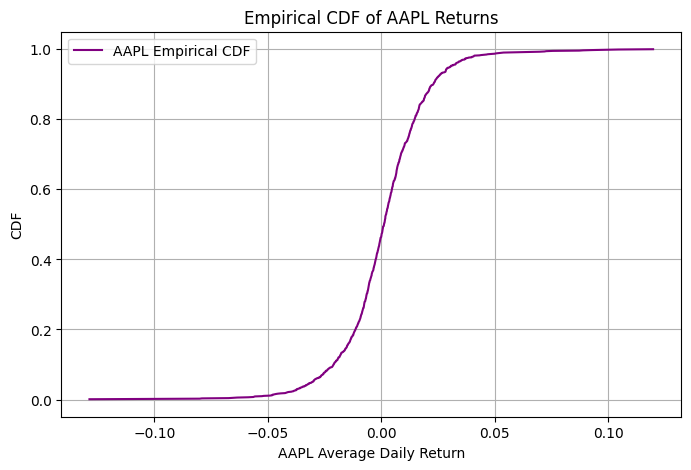

In [17]:
import matplotlib.pyplot as plt
# Sort the data
sorted_data = np.sort(aapl_returns)

# Compute empirical CDF
cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)

# Plot
plt.figure(figsize=(8,5))
plt.plot(sorted_data, cdf, label="AAPL Empirical CDF", color="purple")
plt.xlabel("AAPL Average Daily Return")
plt.ylabel("CDF")
plt.title("Empirical CDF of AAPL Returns")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
aapl_probabilities = []
for i in aapl_returns:
    prob_value = LPM_torch(degree=0, target=i, variables=aapl_torch, excess_ret=False)
    aapl_probabilities.append(prob_value)

# Create scatter plot with trendline
fig = px.scatter(
    x=np.sort(aapl_returns), 
    y=np.sort(aapl_probabilities),
    width=1500, 
    height=1000,
    labels={
        'x': 'AAPL Returns (sorted)',
        'y': 'LPM₀ / Empirical CDF'
    },
    title='Empirical CDF of AAPL Returns via LPM₀'
)

# Optionally add marker style
fig.update_traces(marker=dict(color='red', size=8))

# Show the figure
fig.show()


In [19]:
sp500_probabilities = []
for i in sp500_returns:
    prob_value = LPM_torch(degree=0, target=i, variables=sp500_torch, excess_ret=False)
    sp500_probabilities.append(prob_value)


# Create scatter plot with trendline
fig = px.scatter(
    x=np.sort(sp500_returns), 
    y=np.sort(sp500_probabilities),
    width=1500, 
    height=1000,
    labels={
        'x': 'SP500 Returns (sorted)',
        'y': 'LPM₀ / Empirical CDF'
    },
    title='Empirical CDF of SPY Returns via LPM₀'
)

# Optionally add marker style
fig.update_traces(marker=dict(color='red', size=8))

# Show the figure
fig.show()


In [20]:
import plotly.express as px

fig = px.scatter(
    x=aapl_returns, 
    y=sp500_returns,
    trendline="ols",  # Add trendline
    marginal_x="histogram", 
    marginal_y="histogram", 
    labels={'x':'AAPL Returns', 'y':'S&P 500 Returns'}, 
    title="AAPL vs S&P 500 Returns",
    width=1500,   # set width
    height=1000    # set height
)
fig.show()


In [21]:
from scipy.stats import norm

#
import numpy as np
from scipy.stats import norm

# Convert to numpy array if needed
probs = np.array(aapl_probabilities)

# Clip to avoid exact 0 or 1
eps = 1e-10
probs_clipped = np.clip(probs, eps, 1 - eps)

# Compute z-scores
z_scores = norm.ppf(probs_clipped)



import plotly.express as px
fig = px.scatter(
    x=z_scores, 
    y=aapl_returns,
    trendline="ols",  # Add trendline
    marginal_x="histogram",
    marginal_y="histogram",
    labels={'x':'AAPL Returns (z-scores)', 'y':'AAPL Returns'},
    title="AAPL Returns vs. Z-scores from Empirical CDF",
    width=1500,   # set width
    height=1000    # set height
)
fig.show()

In [22]:
import plotly.express as px

# Make sure you have statsmodels installed
# pip install statsmodels

fig = px.scatter(
    x=aapl_probabilities,
    y=sp500_probabilities,
    marginal_x="histogram",
    marginal_y="histogram",
    trendline="ols",        # Ordinary least squares trendline
    trendline_scope="overall",  # Fit trendline to all data
    labels={'x': 'AAPL Returns', 'y': 'S&P 500 Returns'},
    title="AAPL vs S&P 500 Returns with 95% CI",
    width=1500,
    height=1000
)

fig.show()


Above we can see that we have generated a copula of the returns of aapl and spy respectively using LPMs to create this.

# NNS regression using partial moments

In [23]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau, norm

def dependence_measures(aapl_returns, sp500_returns, alpha=0.05):
    results = {}

    # ---------- 1. Pearson correlation ----------
    rho, pval = pearsonr(aapl_returns, sp500_returns)
    results["Pearson correlation"] = rho
    results["Pearson p-value"] = pval

    # ---------- 2. Spearman & Kendall ----------
    spearman_corr, _ = spearmanr(aapl_returns, sp500_returns)
    kendall_corr, _ = kendalltau(aapl_returns, sp500_returns)
    results["Spearman correlation"] = spearman_corr
    results["Kendall tau"] = kendall_corr

    # ---------- 3. Gaussian copula correlation ----------
    # Pseudo-observations
    u = (np.argsort(np.argsort(aapl_returns)) + 1) / (len(aapl_returns)+1)
    v = (np.argsort(np.argsort(sp500_returns)) + 1) / (len(sp500_returns)+1)

    # Transform to normal space
    z_u = norm.ppf(u)
    z_v = norm.ppf(v)
    copula_corr = np.corrcoef(z_u, z_v)[0,1]
    results["Gaussian copula correlation"] = copula_corr

    # ---------- 4. Tail dependence ----------
    u_emp = np.argsort(np.argsort(aapl_returns)) / len(aapl_returns)
    v_emp = np.argsort(np.argsort(sp500_returns)) / len(sp500_returns)
    lower_tail = np.mean((u_emp < alpha) & (v_emp < alpha)) / alpha
    upper_tail = np.mean((u_emp > 1-alpha) & (v_emp > 1-alpha)) / alpha
    results[f"Lower tail dependence ({alpha*100:.0f}%)"] = lower_tail
    results[f"Upper tail dependence ({alpha*100:.0f}%)"] = upper_tail

    return results


# ----- Example usage -----
results = dependence_measures(aapl_returns, sp500_returns, alpha=0.05)

for k, v in results.items():
    print(f"{k}: {v:.4f}")


Pearson correlation: 0.7904
Pearson p-value: 0.0000
Spearman correlation: 0.7302
Kendall tau: 0.5532
Gaussian copula correlation: 0.7618
Lower tail dependence (5%): 0.6364
Upper tail dependence (5%): 0.4932


In [24]:
cupm = cupm_torch(aapl_returns, sp500_returns, target_x=np.mean(aapl_returns), target_y=np.mean(sp500_returns), degree=1, ddof=1)
clpm = clpm_torch(aapl_returns, sp500_returns, target_x=np.mean(aapl_returns), target_y=np.mean(sp500_returns), degree=1, ddof=1)
dupm = dupm_torch(aapl_returns, sp500_returns, target_x=np.mean(aapl_returns), target_y=np.mean(sp500_returns), degree=1, ddof=1)
dlpm = dlpm_torch(aapl_returns, sp500_returns, target_x=np.mean(aapl_returns), target_y=np.mean(sp500_returns), degree=1, ddof=1)

# NNS regression using partial moments
print(f"The correlation coefficient is calculated as:",(cupm + clpm - dlpm - dupm) / ((var_torch(aapl_returns)**0.5)  * (var_torch(sp500_returns)**0.5)))
print(f"Pearson correlation from scipy:", pearsonr(aapl_returns, sp500_returns)[0])

The correlation coefficient is calculated as: tensor(0.7904, dtype=torch.float64)
Pearson correlation from scipy: 0.7903870268888835


So we can use partial moments to capture linear correlation, but how can we now capture non-linear dependence relationships between x -> y?

In [25]:
cupm, clpm, dupm, dlpm

(tensor(0.0001, dtype=torch.float64),
 tensor(0.0001, dtype=torch.float64),
 tensor(4.0124e-06, dtype=torch.float64),
 tensor(4.0271e-06, dtype=torch.float64))

Below we can observe some insight into the dependence structure of the returns, we see that the co partial quantrants are where most of the data is held and not the divergent quadrants, this is an indication of high correlation.

There are so many insights that you can make from these quadrants: 
1. You can look the concentration of co to divergent to gather insight on the positive or negative correlation
2. You can look at the dupm and clpm concentration versus the cupm and dlpm to get there lower convergence versus there upper convergence.
3. 

In [26]:
print("dependence structure:", (clpm + cupm) /(cupm + clpm + dupm + dlpm))
print("dependence structure:", (dlpm + dupm) /(cupm + clpm + dupm + dlpm))




dependence structure: tensor(0.9648, dtype=torch.float64)
dependence structure: tensor(0.0352, dtype=torch.float64)


Two assets can be correlated whether they converge or diverge, however this conergence and divergence can be different depending of a given asset x is moving up or down, for example the x and y can be converging when x moves up, meaning that there is a high concentration of data points in the co upper quadrants, but they could have a high divergence correlation when x moves down, exhibited by a lot of values in the dlpm, so taking just the covariance is not the best predictor of dependency because it will measure the totla movement regardless of whether the x moves up or down, so an lpm ration that measures the concentration of dta points in colpm vs dupm and the coupm and dupm, and averaging this will be a better measure of dependence that can fit the strucutre of the dependence relationship

UPM ratio: (tensor(0.9627, dtype=torch.float64), tensor(0.0373, dtype=torch.float64))
LPM ratio: (tensor(0.9666, dtype=torch.float64), tensor(0.0334, dtype=torch.float64))


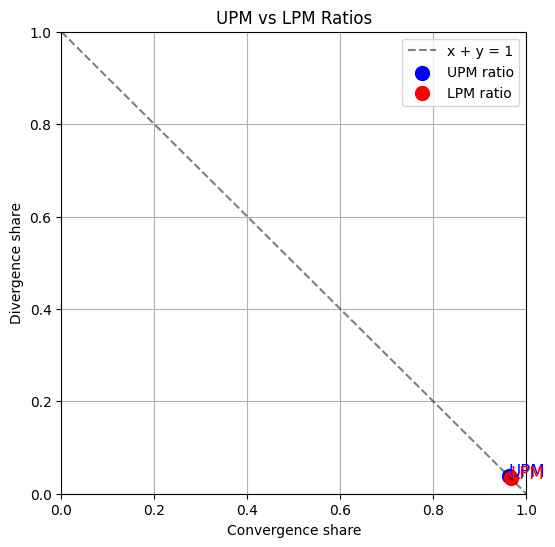

In [27]:
upm_ratio  = cupm / (dupm + cupm), dupm / (dupm + cupm)
lpm_ratio  = clpm / (dlpm + clpm), dlpm / (dlpm + clpm)
print("UPM ratio:", upm_ratio)
print("LPM ratio:", lpm_ratio)
# Plot
plt.figure(figsize=(6,6))
plt.plot([0,1], [1,0], 'k--', alpha=0.5, label="x + y = 1")  # diagonal reference

plt.scatter(*upm_ratio, color="blue", s=100, label="UPM ratio")
plt.scatter(*lpm_ratio, color="red", s=100, label="LPM ratio")

# Annotate
plt.text(upm_ratio[0], upm_ratio[1], "UPM", fontsize=12, color="blue")
plt.text(lpm_ratio[0], lpm_ratio[1], "LPM", fontsize=12, color="red")

# Formatting
plt.xlabel("Convergence share")
plt.ylabel("Divergence share")
plt.title("UPM vs LPM Ratios")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()

The correlation coefficient is calculated as: tensor(-0.0115, dtype=torch.float64)


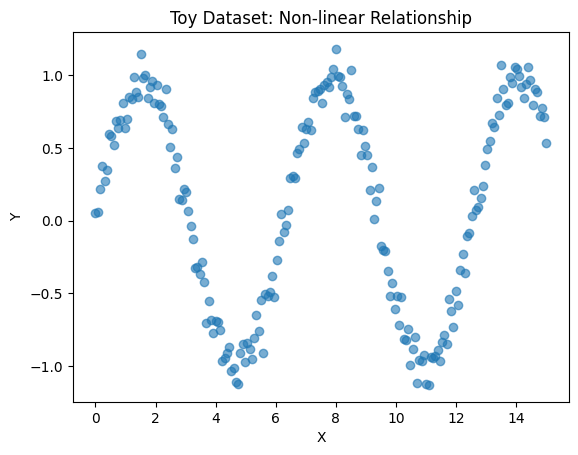

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Generate toy dataset
np.random.seed(42)
start = 0
end = 15
X = np.linspace(start, end, 200)
Y = np.sin(X) + 0.1 * np.random.randn(len(X))

# compute the dependence
cupm = cupm_torch(X, Y, target_x=np.mean(X), target_y=np.mean(Y), degree=1, ddof=1)
clpm = clpm_torch(X, Y, target_x=np.mean(X), target_y=np.mean(Y), degree=1, ddof=1)
dupm = dupm_torch(X, Y, target_x=np.mean(X), target_y=np.mean(Y), degree=1, ddof=1)
dlpm = dlpm_torch(X, Y, target_x=np.mean(X), target_y=np.mean(Y), degree=1, ddof=1)

def lpm_ratio(x, y, target_x, target_y):
    clpm = clpm_torch(x, y, target_x, target_y, degree=1, ddof=1)
    cupm = cupm_torch(x, y, target_x, target_y, degree=1, ddof=1)
    dlpm = dlpm_torch(x, y, target_x, target_y, degree=1, ddof=1)
    dupm = dupm_torch(x, y, target_x, target_y, degree=1, ddof=1)
    return (clpm + cupm) / (clpm + cupm + dlpm + dupm)

# NNS regression using partial moments
print(f"The correlation coefficient is calculated as:",(cupm + clpm - dlpm - dupm) / ((var_torch(X)**0.5)  * (var_torch(Y)**0.5)))

plt.scatter(X, Y, alpha=0.6)
plt.title("Toy Dataset: Non-linear Relationship")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

7.5
Pearson correlation for lpm: -0.3637950789325819
Pearson correlation for upm: 0.11106638327573862
absolute dependence: 0.23743073110416024


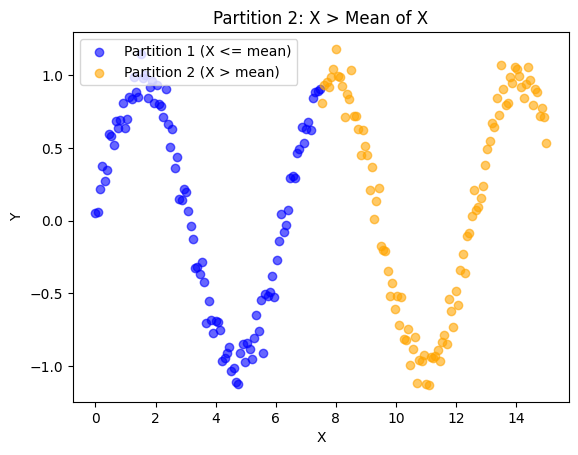

In [29]:
print(np.mean(X))
part_1_x = [x for x, y in zip(X, Y) if x <= np.mean(X)]
part_1_y = [y for x, y in zip(X, Y) if x <= np.mean(X)]
part_2_x = [x for x, y in zip(X, Y) if x > np.mean(X)]
part_2_y = [y for x, y in zip(X, Y) if x > np.mean(X)]



print(f"Pearson correlation for lpm:", pearsonr(part_1_x, part_1_y)[0])
print(f"Pearson correlation for upm:", pearsonr(part_2_x, part_2_y)[0])
print(f"absolute dependence:", (abs(pearsonr(part_1_x, part_1_y)[0]) + abs(pearsonr(part_2_x, part_2_y)[0]))/2)

plt.scatter(part_1_x, part_1_y, color='blue', alpha=0.6, label='Partition 1 (X <= mean)')
plt.title("Partition 1: X <= Mean of X")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

plt.scatter(part_2_x, part_2_y, color='orange', alpha=0.6, label='Partition 2 (X > mean)')
plt.title("Partition 2: X > Mean of X")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


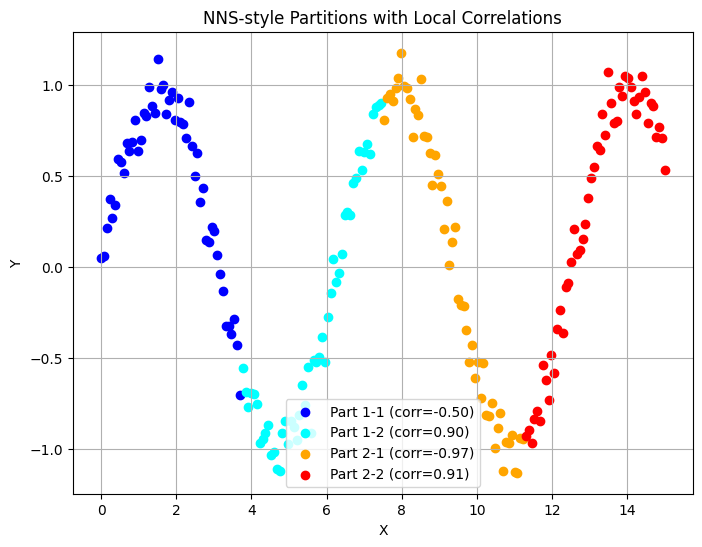

Pearson correlation for lpm of lpm: -0.4952773303548733
Pearson correlation for upm of lpm: 0.8972171011715819
absolute dependence of lpm: 0.6962472157632276
Pearson correlation for lpm of upm: -0.9702802106054902
Pearson correlation for upm of upm: 0.9075150347316184
absolute dependence of upm: 0.9388976226685544
Absolute dependence of Part 1: 0.696
Absolute dependence of Part 2: 0.939
Total absolute dependence: 0.818


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Example partition data (replace with your real data)
# part_1_x, part_1_y, part_2_x, part_2_y need to be defined
# For demo, let's assume they exist as lists or arrays

# Partition 1
part_1_1_x = [x for x, y in zip(part_1_x, part_1_y) if x <= np.mean(part_1_x)]
part_1_1_y = [y for x, y in zip(part_1_x, part_1_y) if x <= np.mean(part_1_x)]
part_1_2_x = [x for x, y in zip(part_1_x, part_1_y) if x > np.mean(part_1_x)]
part_1_2_y = [y for x, y in zip(part_1_x, part_1_y) if x > np.mean(part_1_x)]

# Partition 2
part_2_1_x = [x for x, y in zip(part_2_x, part_2_y) if x <= np.mean(part_2_x)]
part_2_1_y = [y for x, y in zip(part_2_x, part_2_y) if x <= np.mean(part_2_x)]
part_2_2_x = [x for x, y in zip(part_2_x, part_2_y) if x > np.mean(part_2_x)]
part_2_2_y = [y for x, y in zip(part_2_x, part_2_y) if x > np.mean(part_2_x)]

# Compute correlations
corrs = [
    pearsonr(part_1_1_x, part_1_1_y)[0],
    pearsonr(part_1_2_x, part_1_2_y)[0],
    pearsonr(part_2_1_x, part_2_1_y)[0],
    pearsonr(part_2_2_x, part_2_2_y)[0]
]

# Plot partitions
plt.figure(figsize=(8, 6))
plt.scatter(part_1_1_x, part_1_1_y, color='blue', label=f'Part 1-1 (corr={corrs[0]:.2f})')
plt.scatter(part_1_2_x, part_1_2_y, color='cyan', label=f'Part 1-2 (corr={corrs[1]:.2f})')
plt.scatter(part_2_1_x, part_2_1_y, color='orange', label=f'Part 2-1 (corr={corrs[2]:.2f})')
plt.scatter(part_2_2_x, part_2_2_y, color='red', label=f'Part 2-2 (corr={corrs[3]:.2f})')

plt.title("NNS-style Partitions with Local Correlations")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

# Absolute dependences

print(f"Pearson correlation for lpm of lpm:", pearsonr(part_1_1_x, part_1_1_y)[0])
print(f"Pearson correlation for upm of lpm:", pearsonr(part_1_2_x, part_1_2_y)[0])
print(f"absolute dependence of lpm:", (abs(pearsonr(part_1_1_x, part_1_1_y)[0]) + abs(pearsonr(part_1_2_x, part_1_2_y)[0]))/2)
print(f"Pearson correlation for lpm of upm:", pearsonr(part_2_1_x, part_2_1_y)[0])
print(f"Pearson correlation for upm of upm:", pearsonr(part_2_2_x, part_2_2_y)[0])  
print(f"absolute dependence of upm:", (abs(pearsonr(part_2_1_x, part_2_1_y)[0]) + abs(pearsonr(part_2_2_x, part_2_2_y)[0]))/2)

abs_dep_1 = (abs(corrs[0]) + abs(corrs[1])) / 2
abs_dep_2 = (abs(corrs[2]) + abs(corrs[3])) / 2
total_abs_dep = (abs(corrs[0]) + abs(corrs[1]) + abs(corrs[2]) + abs(corrs[3])) / 4

print(f"Absolute dependence of Part 1: {abs_dep_1:.3f}")
print(f"Absolute dependence of Part 2: {abs_dep_2:.3f}")
print(f"Total absolute dependence: {total_abs_dep:.3f}")


/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/1571645147.py:39: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/1571645147.py:39: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/1571645147.py:39: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/1571645147.py:39: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/1571645147.py:39: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/1571645147.py:39: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/1571645147.py:39: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/1571645147.py:39: R

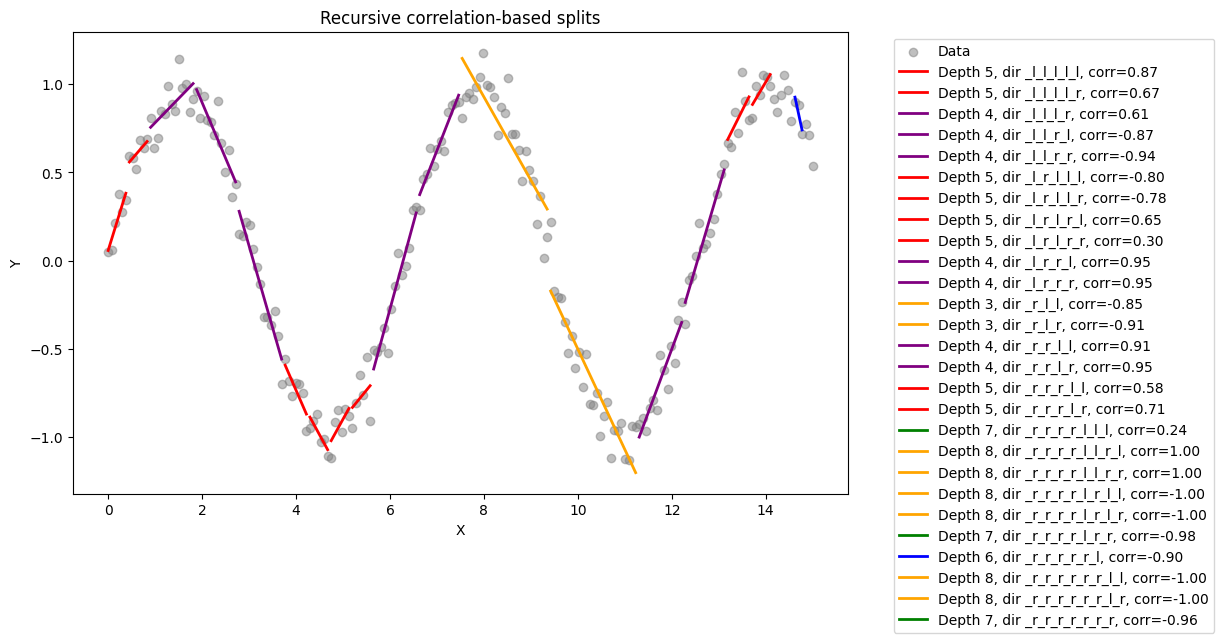

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def dfs(x, y, depth, max_depth, previous_corr, direction=""):
    if len(x) <= 1 or depth >= max_depth:
        return [(depth, direction, previous_corr, x, y)]
    corr = pearsonr(x, y)[0]
    if abs(corr) <= abs(previous_corr) and abs(corr) > 0.3:
        return [(depth, direction, corr, x, y)]
    results = []
    mean_x = np.mean(x)
    left_x = [xi for xi in x if xi <= mean_x]
    left_y = [yi for xi, yi in zip(x, y) if xi <= mean_x]
    right_x = [xi for xi in x if xi > mean_x]
    right_y = [yi for xi, yi in zip(x, y) if xi > mean_x]

    results += dfs(left_x, left_y, depth+1, max_depth, corr, direction= direction + '_l')
    results += dfs(right_x, right_y, depth+1, max_depth, corr, direction= direction + '_r')
    return results


dfs_results = dfs(X, Y, depth=0, max_depth=10, previous_corr=0)

# --- PLOT ---
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, color="gray", alpha=0.5, label="Data")

colors = ["red", "blue", "green", "orange", "purple"]

for i, (depth, direction, corr, x_part, y_part) in enumerate(dfs_results):
    # Sort so the line looks continuous
    xs = np.array(x_part)
    ys = np.array(y_part)
    order = np.argsort(xs)
    xs, ys = xs[order], ys[order]

    # Fit a linear regression line to visualize correlation
    coef = np.polyfit(xs, ys, 1)
    poly_fn = np.poly1d(coef)

    plt.plot(xs, poly_fn(xs),
             color=colors[depth % len(colors)],
             linewidth=2,
             label=f"Depth {depth}, dir {direction}, corr={corr:.2f}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Recursive correlation-based splits")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/951180899.py:27: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/951180899.py:27: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/951180899.py:27: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/951180899.py:27: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/951180899.py:27: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/951180899.py:27: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/951180899.py:27: RankWarning:

Polyfit may be poorly conditioned

/var/folders/_n/0wd0y54973jfy3blt337vjz00000gn/T/ipykernel_1500/951180899.py:27: RankWarni

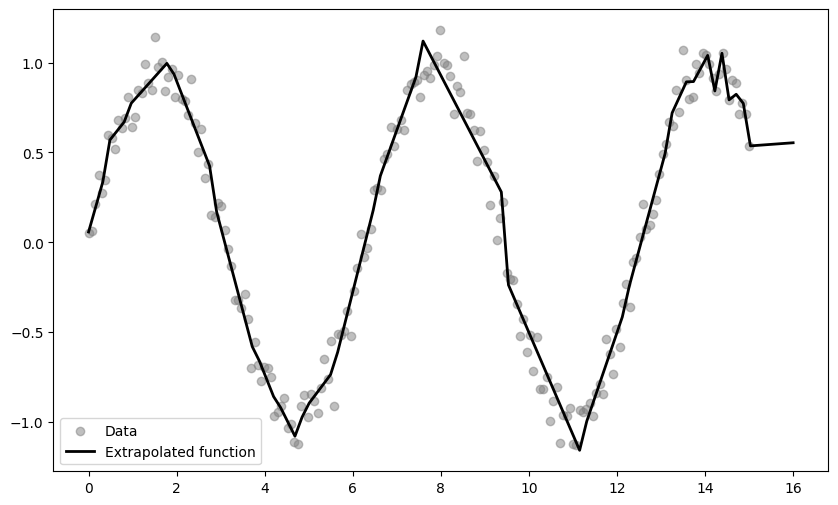

In [32]:
def predict(x_new, dfs_results):
    """
    Predict value(s) for new x using piecewise linear functions
    from dfs_results.
    """
    preds = []
    for x_val in np.atleast_1d(x_new):
        # Find segment whose x-range is closest
        best_seg = None
        best_dist = float("inf")
        for depth, direction, corr, xs, ys in dfs_results:
            xs = np.array(xs)
            if xs.size == 0:
                continue
            seg_min, seg_max = xs.min(), xs.max()
            if seg_min <= x_val <= seg_max:
                best_seg = (xs, ys)
                break
            else:
                # outside domain: pick nearest boundary
                dist = min(abs(x_val - seg_min), abs(x_val - seg_max))
                if dist < best_dist:
                    best_seg = (xs, ys)
                    best_dist = dist
        # Fit line for chosen segment
        xs, ys = best_seg
        coef = np.polyfit(xs, ys, 1)
        poly_fn = np.poly1d(coef)
        preds.append(poly_fn(x_val))
    return np.array(preds)

x_new = np.linspace(start, end + 1, 100)  # beyond original domain
y_pred = predict(x_new, dfs_results)

plt.figure(figsize=(10,6))
plt.scatter(X, Y, color="gray", alpha=0.5, label="Data")
plt.plot(x_new, y_pred, color="black", linewidth=2, label="Extrapolated function")
plt.legend()
plt.show()


# 3. NNS.ARMA model in pytorch
ARMA formula is below: 

$$
X_t = c + \sum^{p}_{i=1}\phi_{i}X_{t-i} + \sum^{q}_{j=1}\theta_j\epsilon_{t-j} + \epsilon_t
$$



In [33]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

# Example time series
np.random.seed(42)
T = 100
x = np.cumsum(np.random.randn(T))

# Fit ARMA(p, q) using ARIMA with d=0
p, d, q = 2, 0, 2
model = sm.tsa.ARIMA(x, order=(p, d, q))
results = model.fit(method="innovations_mle")  # fit via maximum likelihood

# Full summary (like a stats table)
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -132.941
Date:                Wed, 27 Aug 2025   AIC                            277.881
Time:                        17:19:32   BIC                            293.512
Sample:                             0   HQIC                           284.208
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5930      3.459     -1.617      0.106     -12.373       1.187
ar.L1          0.1661      0.240      0.693      0.488      -0.304       0.636
ar.L2          0.8054      0.241      3.337      0.0